In [37]:
# !pip install tensorflow
#!pip install numpy
# !pip install pandas
# !pip install matplotlib

In [38]:
from pathlib import Path
import imghdr
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [39]:
# Image augmentation
data_augmentation = tf.keras.Sequential([
     layers.RandomFlip("horizontal_and_vertical"),
     layers.RandomRotation(0.2)])

image_size = (64, 64)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

# Apply the data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 981 files belonging to 3 classes.
Using 785 files for training.
Found 981 files belonging to 3 classes.
Using 196 files for validation.


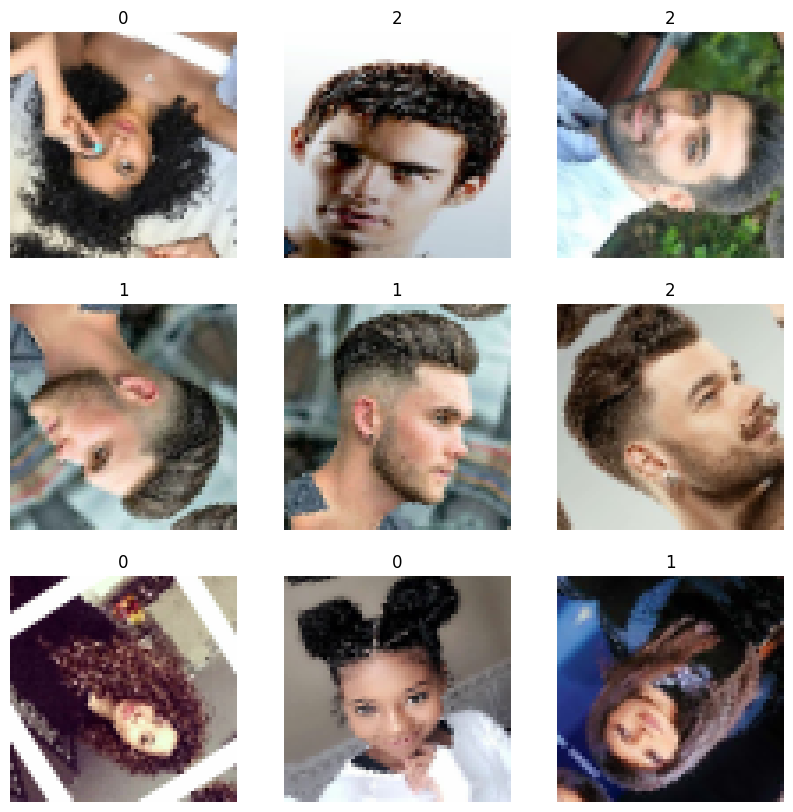

In [40]:


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

In [41]:

model = Sequential()
model.add(keras.Input(shape=image_size + (3,))) # 64, 64, 3
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=4, kernel_size=16, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=8, kernel_size=8, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64))
model.add(layers.Activation("relu"))
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

epochs = 25

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.3447 - loss: 1.0977 - val_accuracy: 0.2857 - val_loss: 1.1022
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.3871 - loss: 1.0926 - val_accuracy: 0.3010 - val_loss: 1.0941
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.4158 - loss: 1.0648 - val_accuracy: 0.4235 - val_loss: 1.0764
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.4447 - loss: 1.0330 - val_accuracy: 0.4184 - val_loss: 1.0838
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.4178 - loss: 1.0587 - val_accuracy: 0.4898 - val_loss: 1.0685
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.4603 - loss: 1.0215 - val_accuracy: 0.4949 - val_loss: 1.0392
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.4492 - loss: 1.0469 - val_accuracy: 0.3622 - val_loss: 1.1991
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━

In [42]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
This image is 0.65 percent curly hair, 0.22 percent straight hair, and 0.13 percent wavy hair.
